# Python guide for lazy clinical chemists

Welcome! So you want to start your first project in Python? Great stuff.

## Setup

The easiest way to get up and running with Python is to install the [Anaconda](https://www.anaconda.com/products/individual) environment. It will install the base Python language and useful data science libraries. Next, you want to install [JupyterLab](https://jupyter.org/index.html), which enables you to work on flashy interactive notebooks.

## Tools

* [Python](https://www.python.org/): a general programming language favored by the data science community. [Here](https://docs.python-guide.org/intro/learning/) are some great resources.
* [NumPy](https://numpy.org/doc/stable/) package for scientific computing. Use this for your number crunching.
* [SciPy](https://docs.scipy.org/doc/scipy/reference/) numpy extension with useful algorithms
* [Pandas](https://pandas.pydata.org/) package for data analysis and manipulation
* [matplotlib](https://matplotlib.org/) package for plotting graphs
* [seaborn](https://seaborn.pydata.org/) package for statistical visualization, uses matplotlib under the hood

All of the above is installed for you if you use Anaconda

# Example Project: Fit a logistic function
 
Let's get our hands dirty and try to use the above mentioned tools. Our goal is to fit a logistic function to the sample data, so some characteristics of the data can be inferred.

## Step 1: Generate test data

Browsing Wikipedia we can look up the [definition](https://en.wikipedia.org/wiki/Generalised_logistic_function) of a logistic function.

$$Y(t) = A + { K-A \over (C + Q e^{-B t}) ^ {1 / \nu} }$$

For simplicity's sake we let $A = 0$ and $C = 1$. This means the lower asymptote will always start at 0.

### Coding the function

We can code this method using the `def` Python keyword. Notice how we `import math`. This means we are pulling in a package (such as `math`, `numpy` etc), which can later be used by us.

In [ ]:
import math

# A = 0, C = 1
def logistic(K, B, v, Q, t):
    return K / math.pow(1 + Q*math.exp(-B *t), 1/v)

### Randomize function parameters

Let's randomize some values for the function parameters $K, B, v, Q$.

In [948]:
K, B, v, Q = np.random.uniform(low=1, high=4, size=4)

You can inspect Python variables at any time with `print`. In Jupyter you can also put the variables on the last line of the cell. Let's try it out!

In [951]:
print(K, B, v, Q)

1.686238153623501 2.9785423991875932 3.4156433658738345 2.882186886480124


In [952]:
K, B, v, Q

(1.686238153623501, 2.9785423991875932, 3.4156433658738345, 2.882186886480124)

### Generate the data

Let's sample 200 measurements for this logistic curve. We consider $ -10 \leq x \leq 10$, since smaller or higher values will just remain stable.

In [963]:
num_measurements = 200
min_x = -10
max_x = 10

# generate 200 evenly spaced x steps
x_gen = np.linspace(min_synthetic, max_synthetic, num_measurements)
# apply logistic function to all x steps
y_gen = [logistic(K, B, v, Q, t) for t in t_synthetic]

To make the sample more realistic, we add a timestamp to the measured sample, and some measuring noise. The noise $\epsilon ~ \mathcal{N}(0, 0.02)$, i.e. [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution). This is a common way to simulate noise.

In [964]:
measure_sec = 10
base_time = datetime(2020, 12, 4, 10)
time_gen = [base_time + timedelta(minutes = measure_sec*step)
               for step in range(num_measurements)]
noise = np.random.normal(0, 0.03, num_measurements)
measurements = y_gen + noise

### Plot the data

We now have the generated data and its timestamps. We can put this into a nice format using Pandas, and then plot it with Seaborn.

There are some things to unpack here. `%matplotlib inline` is a special command to enable drawing plots directly in Jupyter. The `zip` function takes two lists $[a_1\ldots,a_n]$ and $[b_1\ldots,b_n]$ and transforms this into $[(a_1, b_1), \ldots, (a_n,b_n)]$. This is the required format for Pandas.

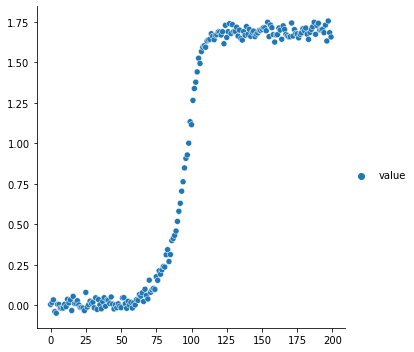

In [966]:
%matplotlib inline
data = pd.DataFrame(zip(time_values, measurements), columns=["time", "value"])
sns.relplot(data=data)

## Step 2: Fit test data to function

In the next step we want to fit our test data to our model, the logistic function. Let's pretend we don't know the true generative function, we just know the sample data. The sample data may be noisy however, and it might be a lot easier to analyze the model than the data itself.

### Scaling the data
Our example data is using timesteps $0 \leq t \leq 200$, whereas our logistic function is typically only used for $-10 \leq x \leq 10$.

To properly fit the curve we have to scale our $t$ steps into $x$ steps that make sense for the function we want to fit.

In [968]:
def scale_time_value(t, num_measurements):
    scale = num_measurements / 20
    return t / scale - 10

### Fitting the data

There are a few ways to fit a curve using the [SciPy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) package. One method we can use is [Differential Evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolutiona), which tries to minimize a function stochastically.

Since we are interesting in the best fit for our parameters, we want to minimze the difference between the model data and the observed data. This is typically expressed as least squares.

In [971]:
time_steps = list(data.index)
scaled_time_steps = [scale_time_value(t, num_measurements) for t in time_steps]
values = data.value.to_numpy()

def sum_squared(params):
    (K_c, B_c, v_c, Q_c) = params
    new_values = [logistic(K_c, B_c, v_c, Q_c, t) for t in scaled_time_steps]
    return np.sum((values - new_values) ** 2.0)

Differential evolution requires us to specify bounds on the parameters we search for. The `seed` parameter determines what random process the use. Same seed, same outcome.

In [973]:
from scipy.optimize import differential_evolution

def find_params():
    bounds = [
        [1.0, 10.0], # search bounds for K
        [1.0, 10.0], # search bounds for B
        [1.0, 10.0],  # search bounds for v
        [1.0, 10.0], # search bounds for Q
    ]

    result = differential_evolution(sum_squared, bounds, seed=3)
    return result.x

Let's find some good params and plot them.

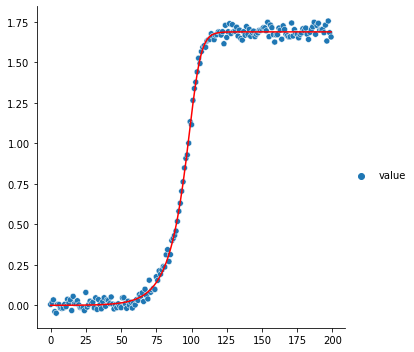

In [975]:
K_f, B_f, v_f, Q_f = find_params()
value_fit = [logistic(K_f, B_f, v_f, Q_f, t) for t in scaled_time_steps]
data_fit = pd.DataFrame(zip(time_values, value_fit), columns=["time", "value"])

sns.relplot(data=data)
plt.plot(time_steps, value_fit, color="r")
plt.show()

## Step 3: Infer information about the data

We now have a model that fits our data pretty well. Say that we want to infer when in the data the values start to grow, and when they stop. This can in turn be inferred from when values in the model start and stop to grow. The point where this happen is somewhat arbitrary, so we have to define what we mean. Let's say we care about the point where values have grown by 5% from the start and end.

In [ ]:
threshold = 0.05

In [979]:
y = data_fit.value.to_numpy()
right_threshold = len(y)-1
for j in range(len(y)-1, -1, -1):
     if y[j] < (1 - threshold) * y[-1]:
        right_threshold = j
        break

diff = y[-1] - y[right_threshold]        
left_threshold = 0
for i in range(1, len(y)):
    if y[i] > y[0] + diff:
        left_threshold = i
        break
        

Now that have an estimate for when the data starts and stops growing, we can plot this point together with the data and the model.

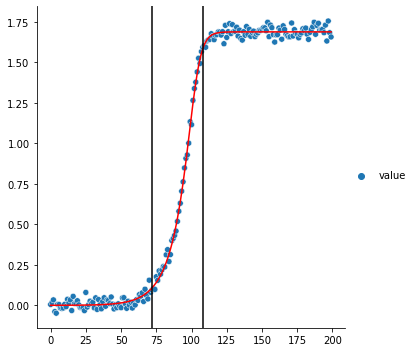

In [981]:
sns.relplot(data=data)
plt.plot(time_steps, value_fit, color="r")
plt.axvline(left_threshold, 0, 1, color='k')
plt.axvline(right_threshold, 0, 1, color='k')
plt.show()

## Happy hacking!